In [578]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import numpy as np
import pandas as pd
import string
import re

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from collections import defaultdict
from gensim import corpora
import gensim

import datetime

In [315]:
df_ = pd.read_csv('../data/yoga.csv')

In [442]:
df = df_.copy().sample(1000, random_state=0).reset_index()

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         1000 non-null   int64  
 1   id            1000 non-null   object 
 2   title         1000 non-null   object 
 3   description   946 non-null    object 
 4   channelTitle  1000 non-null   object 
 5   tags          801 non-null    object 
 6   categoryId    1000 non-null   int64  
 7   duration      1000 non-null   object 
 8   viewCount     1000 non-null   float64
 9   likeCount     1000 non-null   float64
 10  dislikeCount  1000 non-null   float64
 11  commentCount  1000 non-null   float64
dtypes: float64(4), int64(2), object(6)
memory usage: 93.9+ KB


In [444]:
df.description.fillna('none', inplace=True)
df.tags.fillna('none', inplace=True)

In [345]:
stop_words = stopwords.words('english')
channel_stop = list(df['channelTitle'].unique())
stop_words.extend(channel_stop)

In [613]:
yoga_stopwords = ['yoga', 'music', 'minute', 'min', 'music', 'teach', 'practice', 'song', 'class', 'playlist', 'none', 'facebook', 'instagram', 'online', 'web', 'exercise', 'video', 'workout', 'free', 'channel', 'home', 'subscribe', 'support', 'series', 'day', 'fitness', 'link', 'risk', 'youtube', 'de', 'website', 'program', 'help', 'content', 'new', 'please', 'work', 'share', 'para', 'ha', 'first', 'technique', 'en', 'twitter', 'la', 'body']
stop_words.extend(yoga_stopwords)

In [496]:
lem = WordNetLemmatizer()

def take_head(text):
    head, sep, tail = text.partition('\n\n')
    return head

def no_emojis(text):
    return text.encode('ascii', 'ignore').decode('ascii')

def remove_hyperlinks(text):
    return re.sub(r'(https?:\/\/\S*)|(www.\S+)}', '', text)

def remove_punctuation(text):
    return ''.join([char for char in text.lower() if char not in string.punctuation])

def remove_numbers(text):
    return ''.join([char for char in text if not char.isdigit()])

def remove_single_char(text):
    return ' '.join([word for word in text.split() if len(word) > 1])

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

def lemmatize_text(text):
    return ' '.join([lem.lemmatize(word) for word in text.split()])


def clean_text(text):
    text = no_emojis(text)
    text = remove_hyperlinks(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_single_char(text)
    text = lemmatize(text)
    text = remove_stopwords(text)
    return text

In [614]:
df['description'].apply(take_head)

0      full body stretch level great evening bed cour...
1      get ripped deluxe edition sale limited time ge...
2                                                       
3      hatha detox cleanse twist wash inner another g...
4      restorative full body stretch restorative rout...
                             ...                        
995    world renowned teacher desire rumbaugh show al...
996    restore repair rejuvenate gentle flow designed...
997    designed seated wheelchair chair wonderful ref...
998    na prtica hoje guio uma aula hatha susana que ...
999    le hatha est un style trs doux et accessible n...
Name: description, Length: 1000, dtype: object

In [615]:
columns = ['title', 'description', 'tags']
for column in columns:
    df[column] = df[column].apply(clean_text)

In [616]:
# df['text'] = list(df['title'] + ' ' + df['description'] + ' ' + df['tags'])
df['text'] = df['title'].apply(str.split) + df['description'].apply(str.split) + df['tags'].apply(str.split)

In [617]:
# remove words that appear only once
frequency = defaultdict(int)
for text in df['text']:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in df['text']
]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

2021-01-12 04:49:25,945 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-01-12 04:49:26,063 : INFO : built Dictionary(7305 unique tokens: ['ache', 'action', 'activity', 'added', 'advanced']...) from 1000 documents (total 106162 corpus positions)


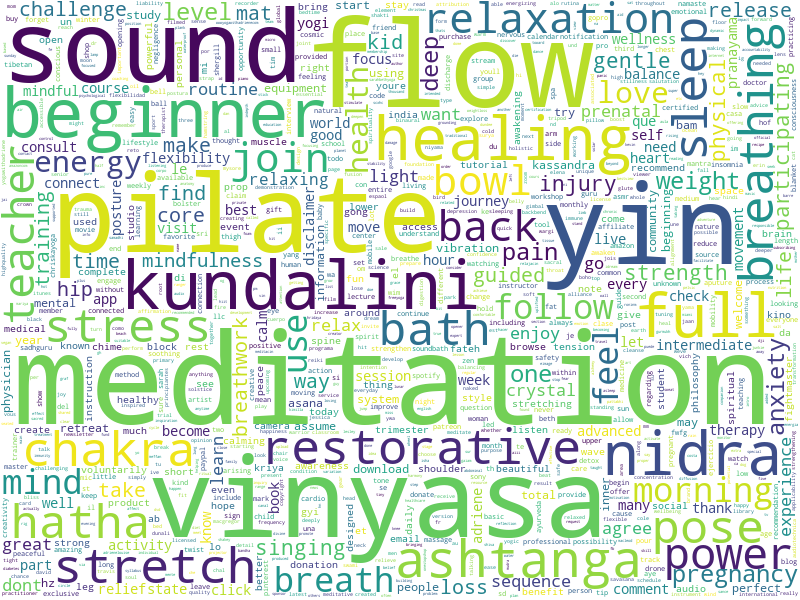

In [618]:
# Import the wordcloud library
from wordcloud import WordCloud
import itertools

# Join the different processed titles together
list_of_words = list(itertools.chain.from_iterable(texts))
long_string = ','.join(word for word in list_of_words)
long_string

# # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, width=800, height=600, contour_width=3, contour_color='steelblue', collocations = False,  random_state=1)

# # Generate a word cloud
wordcloud.generate(long_string)

# # Visualize the word cloud
wordcloud.to_image()

In [619]:
wordcloud.to_file('wordcloud.png')

In [502]:
from gensim import models
lda = models.LdaMulticore(corpus, passes=50, id2word=dictionary, num_topics=12)

2021-01-10 22:05:32,409 : INFO : using symmetric alpha at 0.08333333333333333
2021-01-10 22:05:32,410 : INFO : using symmetric eta at 0.08333333333333333
2021-01-10 22:05:32,413 : INFO : using serial LDA version on this node
2021-01-10 22:05:32,424 : INFO : running online LDA training, 12 topics, 1 passes over the supplied corpus of 1000 documents, updating every 14000 documents, evaluating every ~1000 documents, iterating 50x with a convergence threshold of 0.001000
2021-01-10 22:05:32,425 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-01-10 22:05:32,426 : INFO : training LDA model using 7 processes
2021-01-10 22:05:32,502 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #1000/1000, outstanding queue size 1
2021-01-10 22:05:33,227 : INFO : topic #4 (0.083): 0.014*"sound" + 0.012*"meditation" + 0.012*"de" + 0.010*"healing" + 0.009*"bowl" + 0.007*"channel" + 0.007*"yin" + 0.006*"ba

In [544]:
doc = "beginner"
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lda = lda[vec_bow]  # convert the query to LDA space
# print(vec_lda)

In [545]:
from gensim import similarities
index = similarities.MatrixSimilarity(lda[corpus])  # transform corpus to LDA space and index it

2021-01-10 22:15:14,615 : WARNING : scanning corpus to determine the number of features (consider setting `num_features` explicitly)
2021-01-10 22:15:15,074 : INFO : creating matrix with 1000 documents and 12 features


In [546]:
index.save('/tmp/yoga_lda.index')
index = similarities.MatrixSimilarity.load('/tmp/yoga_lda.index')

2021-01-10 22:15:17,602 : INFO : saving MatrixSimilarity object under /tmp/yoga_lda.index, separately None
2021-01-10 22:15:17,605 : INFO : saved /tmp/yoga_lda.index
2021-01-10 22:15:17,606 : INFO : loading MatrixSimilarity object from /tmp/yoga_lda.index
2021-01-10 22:15:17,608 : INFO : loaded /tmp/yoga_lda.index


In [558]:
sims = index[vec_lda]  # perform a similarity query against the corpus
#print(list(enumerate(sims)))  # print (document_number, document_similarity) 2-tuples

In [559]:
sims = sorted(enumerate(sims), key=lambda item: item[-1], reverse=True)

top_10 = [(doc_position, doc_score) for doc_position, doc_score in sims[0:10]]
#     print(doc_score, df['id'][doc_position])

In [560]:
top_10

[(21, 0.9871708),
 (325, 0.9871695),
 (441, 0.98716223),
 (220, 0.9778721),
 (796, 0.9725807),
 (968, 0.97182095),
 (99, 0.97179973),
 (308, 0.9717794),
 (965, 0.97174585),
 (550, 0.97161996)]

In [567]:
for index in top_10:
    print(df.iloc[index[0]]['id'])

8tHd7wgKkdo
etNjcspY00A
IYlwyJpBUeQ
sjC7JF9UXyU
rXMnYwkxOAo
9Ujxg_7xCFw
wwQryFTd-Kk
xLGRULlJCVk
YOJy4IUDv-Y
yBP85ISVri4


In [516]:

sims = sorted(enumerate(sims), key=lambda item: item[-1])

In [517]:
sims[0]

(0, (0, (397, (0, (397, (0, 0.07454174))))))

In [568]:
from gensim import models

In [569]:
lda = models.LdaModel.load('../app/model_data/lda_model')

2021-01-11 01:19:46,864 : INFO : loading LdaModel object from ../app/model_data/lda_model
2021-01-11 01:19:46,874 : INFO : loading expElogbeta from ../app/model_data/lda_model.expElogbeta.npy with mmap=None
2021-01-11 01:19:46,880 : INFO : setting ignored attribute state to None
2021-01-11 01:19:46,882 : INFO : setting ignored attribute dispatcher to None
2021-01-11 01:19:46,884 : INFO : setting ignored attribute id2word to None
2021-01-11 01:19:46,886 : INFO : loaded ../app/model_data/lda_model
2021-01-11 01:19:46,889 : INFO : loading LdaState object from ../app/model_data/lda_model.state
2021-01-11 01:19:46,916 : INFO : loaded ../app/model_data/lda_model.state


In [575]:
lda[vec_bow]

[(0, 0.04188767),
 (1, 0.04188767),
 (2, 0.04188767),
 (3, 0.04188767),
 (4, 0.04188767),
 (5, 0.5392356),
 (6, 0.04188767),
 (7, 0.04188767),
 (8, 0.04188767),
 (9, 0.04188767),
 (10, 0.04188767),
 (11, 0.04188767)]

In [666]:
top_10

[(21, 0.9871708),
 (325, 0.9871695),
 (441, 0.98716223),
 (220, 0.9778721),
 (796, 0.9725807),
 (968, 0.97182095),
 (99, 0.97179973),
 (308, 0.9717794),
 (965, 0.97174585),
 (550, 0.97161996)]

In [674]:
to_html = pd.DataFrame(columns=df.columns)
for i in top_10:
    to_html = test_df.append(df.iloc[[i[0]]])
print(to_html)

              id                                              title  \
21   8tHd7wgKkdo                              gratitude mindful art   
325  etNjcspY00A                    restorative yin rachel fearnley   
441  IYlwyJpBUeQ                           beginner yin restorative   
220  sjC7JF9UXyU      pilatesyoga fusion dianne joe stayhome withme   
796  rXMnYwkxOAo  relaxing spa healing sleep calming zen spa stu...   
968  9Ujxg_7xCFw  power strength flexibility balance intermediat...   
99   wwQryFTd-Kk                  restorative immune system melissa   
308  xLGRULlJCVk  meditation mindfulness binaural beat study med...   
965  YOJy4IUDv-Y  sound bath meditation therapy leicester gong c...   
550  yBP85ISVri4  rodney yee energy stress relief restorative po...   
21   8tHd7wgKkdo                              gratitude mindful art   
325  etNjcspY00A                    restorative yin rachel fearnley   
441  IYlwyJpBUeQ                           beginner yin restorative   
220  s

In [675]:
columns = ['title', 'description', 'id']
for i in to_html.columns:
    if i not in columns:
        to_html.drop(columns=i, inplace=True)
to_html

,id,title,description
21,8tHd7wgKkdo,gratitude mindful art,
325,etNjcspY00A,restorative yin rachel fearnley,
441,IYlwyJpBUeQ,beginner yin restorative,
220,sjC7JF9UXyU,pilatesyoga fusion dianne joe stayhome withme,insta
796,rXMnYwkxOAo,relaxing spa healing sleep calming zen spa stu...,get yellow brick cinema io app trial relaxing ...
968,9Ujxg_7xCFw,power strength flexibility balance intermediat...,power intermediate challenge strength balance ...
99,wwQryFTd-Kk,restorative immune system melissa,restorative immune system melissa restorative ...
308,xLGRULlJCVk,meditation mindfulness binaural beat study med...,relaxing calm meditation study relaxing zen st...
965,YOJy4IUDv-Y,sound bath meditation therapy leicester gong c...,download journey sound meditation album experi...
550,yBP85ISVri4,rodney yee energy stress relief restorative po...,filmed picturesque western colorado clip dvd e...


In [680]:
to_html['id'] = to_html['id'].apply(lambda x: f'https://www.youtube.com/watch?v={x}')

In [681]:
to_html

,id,title,description
21,https://www.youtube.com/watch?v=8tHd7wgKkdo,gratitude mindful art,
325,https://www.youtube.com/watch?v=etNjcspY00A,restorative yin rachel fearnley,
441,https://www.youtube.com/watch?v=IYlwyJpBUeQ,beginner yin restorative,
220,https://www.youtube.com/watch?v=sjC7JF9UXyU,pilatesyoga fusion dianne joe stayhome withme,insta
796,https://www.youtube.com/watch?v=rXMnYwkxOAo,relaxing spa healing sleep calming zen spa stu...,get yellow brick cinema io app trial relaxing ...
968,https://www.youtube.com/watch?v=9Ujxg_7xCFw,power strength flexibility balance intermediat...,power intermediate challenge strength balance ...
99,https://www.youtube.com/watch?v=wwQryFTd-Kk,restorative immune system melissa,restorative immune system melissa restorative ...
308,https://www.youtube.com/watch?v=xLGRULlJCVk,meditation mindfulness binaural beat study med...,relaxing calm meditation study relaxing zen st...
965,https://www.youtube.com/watch?v=YOJy4IUDv-Y,sound bath meditation therapy leicester gong c...,download journey sound meditation album experi...
550,https://www.youtube.com/watch?v=yBP85ISVri4,rodney yee energy stress relief restorative po...,filmed picturesque western colorado clip dvd e...


In [657]:
test_df

,id,title,description
21,8tHd7wgKkdo,gratitude mindful art,
325,etNjcspY00A,restorative yin rachel fearnley,
441,IYlwyJpBUeQ,beginner yin restorative,
220,sjC7JF9UXyU,pilatesyoga fusion dianne joe stayhome withme,insta
796,rXMnYwkxOAo,relaxing spa healing sleep calming zen spa stu...,get yellow brick cinema io app trial relaxing ...
968,9Ujxg_7xCFw,power strength flexibility balance intermediat...,power intermediate challenge strength balance ...
99,wwQryFTd-Kk,restorative immune system melissa,restorative immune system melissa restorative ...
308,xLGRULlJCVk,meditation mindfulness binaural beat study med...,relaxing calm meditation study relaxing zen st...
965,YOJy4IUDv-Y,sound bath meditation therapy leicester gong c...,download journey sound meditation album experi...
550,yBP85ISVri4,rodney yee energy stress relief restorative po...,filmed picturesque western colorado clip dvd e...


In [658]:
def add_hyperlink(string):
    new_string = f'https://www.youtube.com/watch?v={string}'
    return new_string

In [659]:
test = add_hyperlink('aaaa')

In [665]:
test_df['id'].apply(lambda x: f'https://www.youtube.com/watch?v={x}')

21     https://www.youtube.com/watch?v=8tHd7wgKkdo
325    https://www.youtube.com/watch?v=etNjcspY00A
441    https://www.youtube.com/watch?v=IYlwyJpBUeQ
220    https://www.youtube.com/watch?v=sjC7JF9UXyU
796    https://www.youtube.com/watch?v=rXMnYwkxOAo
968    https://www.youtube.com/watch?v=9Ujxg_7xCFw
99     https://www.youtube.com/watch?v=wwQryFTd-Kk
308    https://www.youtube.com/watch?v=xLGRULlJCVk
965    https://www.youtube.com/watch?v=YOJy4IUDv-Y
550    https://www.youtube.com/watch?v=yBP85ISVri4
Name: id, dtype: object

In [662]:
test_df

,id,title,description
21,8tHd7wgKkdo,gratitude mindful art,
325,etNjcspY00A,restorative yin rachel fearnley,
441,IYlwyJpBUeQ,beginner yin restorative,
220,sjC7JF9UXyU,pilatesyoga fusion dianne joe stayhome withme,insta
796,rXMnYwkxOAo,relaxing spa healing sleep calming zen spa stu...,get yellow brick cinema io app trial relaxing ...
968,9Ujxg_7xCFw,power strength flexibility balance intermediat...,power intermediate challenge strength balance ...
99,wwQryFTd-Kk,restorative immune system melissa,restorative immune system melissa restorative ...
308,xLGRULlJCVk,meditation mindfulness binaural beat study med...,relaxing calm meditation study relaxing zen st...
965,YOJy4IUDv-Y,sound bath meditation therapy leicester gong c...,download journey sound meditation album experi...
550,yBP85ISVri4,rodney yee energy stress relief restorative po...,filmed picturesque western colorado clip dvd e...


In [721]:
array = np.zeros((3,3))

In [694]:
a = array.flatten()

In [717]:
start = 1
for i, e in enumerate(array.flatten()):
    array.flatten()[i] = start
    start += 1
    print(i)
    print(start)

0
2
1
3
2
4
3
5
4
6
5
7
6
8
7
9
8
10


In [728]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14619 entries, 0 to 14618
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            14619 non-null  object 
 1   title         14619 non-null  object 
 2   description   14065 non-null  object 
 3   channelTitle  14619 non-null  object 
 4   tags          11971 non-null  object 
 5   categoryId    14619 non-null  int64  
 6   duration      14619 non-null  object 
 7   viewCount     14619 non-null  float64
 8   likeCount     14619 non-null  float64
 9   dislikeCount  14619 non-null  float64
 10  commentCount  14619 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 1.2+ MB
